In [1]:
import pennylane as qml
from pennylane import numpy as np
from IPython.display import display, Latex

# from numba import jit

# numpy 
import numpy as np_
import scipy as sp

import matplotlib.pyplot as plt

# 2-qubit
dev = qml.device('default.mixed', wires= 2)

# == Hamiltonian setup == 
coeffs = [1]
obs = [qml.PauliZ(0) @ qml.PauliZ(1)]

hamiltonian = qml.Hamiltonian(coeffs, obs)

In [2]:
# # == Generate circuit == 

# global var
    # theta_init, tau_1, tau_2 = paras
    # np.pi/2, 1.653, 0.999
    
Paras_global = np.zeros(3)
Phi_global = None

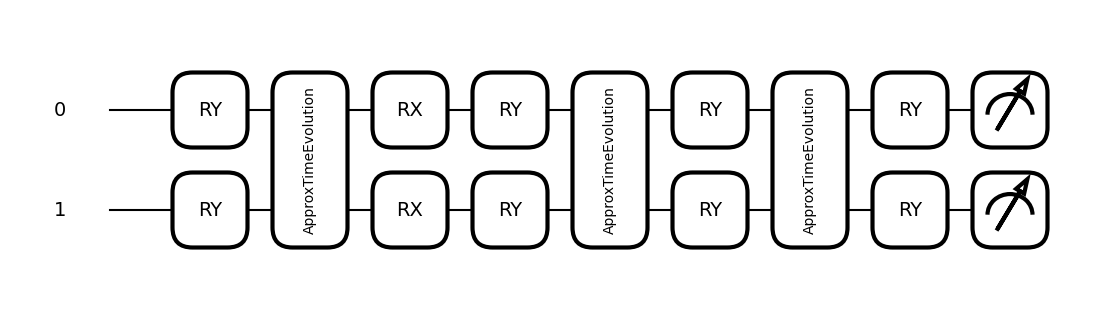

In [3]:
@qml.qnode(dev)
def circuit_alt(phi):
    theta_init, tau_1, tau_2 = Paras_global[0], Paras_global[1], Paras_global[2]
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(hamiltonian, -tau_1/2, 1)
    
    qml.RX(theta_init, wires = 0)    
    qml.RX(theta_init, wires = 1)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   

    qml.ApproxTimeEvolution(hamiltonian, -tau_2/2, 1)

    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(hamiltonian, -phi/2, 1)
    
    # qml.RX(np.pi/2, wires=0)
    # qml.RX(np.pi/2, wires=1)
    
    qml.RY(-np.pi/(2+1e-6), wires=0)
    qml.RY(-np.pi/(2+1e-6), wires=1)
    
    return qml.density_matrix(wires=[0, 1])

fig, ax = qml.draw_mpl(circuit_alt)(0)

In [4]:
# == Post-selection ==

# set gamma_ps 
Gamma_ps = 0
Optimized_paras = 1.57100339,1.65353155, 0.99999988

# ALT
@qml.qnode(dev)
def Post_selection_alt(phi):
    
    global Paras_global
    Paras_global = Optimized_paras
    
    # Get density matrix from circuit_2
    density_matrix = circuit_alt(phi)
    qml.QubitDensityMatrix(density_matrix, wires=[0, 1])
    
    # Kraus operator for 2*2 matrix
    K = np.array([ [np.sqrt(1 - Gamma_ps), 0], [0, 1] ])
    
    Numerator = np.kron(K, np.eye(2)) @ density_matrix @ np.kron(K, np.eye(2)).conj().T
    Denominator = np.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires=[0, 1])
    
    return qml.density_matrix(wires=[0, 1])

In [5]:
# == Variables define for plot ==

# Sweep boundaries
Select_bound = np_.array([1e-4, np.pi * 4 + 1e-4])
Numerator_of_N = (Select_bound[1] - Select_bound[0])

# N = int((Numerator_of_N / np.pi) * 31)
N = 100

Step_size_cal = Numerator_of_N / N

# == pi / 31 ==
# Optimal step size = 0.10134169850289655

# gamma
Gamma = 0.2, 0.3, 0.4
Num_CFI = len(Gamma)


# Print out status
print('Optimal step-size for arange:', Step_size_cal, '\nN:', N)

text_latex = r'$\gamma$ ='
display(Latex(text_latex))
for i in range(Num_CFI):
    print(Gamma[i],' ', end="")

Optimal step-size for arange: 0.12566370614359174 
N: 100


<IPython.core.display.Latex object>

0.2  0.3  0.4  

In [6]:
# == Plot CFI using np.arange with N = 100 ==

# @jit(nopython = True)
def CFI_arange(Sweep_bound, Step_size, Gamma):
    
    # Searching range 
    Phi_range = np.arange(Sweep_bound[0], Sweep_bound[1], Step_size)
    
    # Define as original numpy
    Num_CFI = len(Gamma)
    CFI = np_.zeros((Num_CFI, len(Phi_range)))
    
    for i in range(Num_CFI):
        for j in range(len(Phi_range)):
            # Set global var
            global Gamma_ps
            Gamma_ps = Gamma[i]
            Temp = qml.qinfo.classical_fisher(Post_selection_alt)(Phi_range[j])
        
            # Casting to np.array
            CFI[i][j] = np.array(Temp[0], requires_grad = 'False')
        
            Temp = np.zeros(1)  
            
    for i in range(Num_CFI):
        plt.plot(Phi_range, CFI[i][:], label = f'$\gamma_{{ps}}$ = {Gamma[i]}')
    
    plt.title(f'CFI:[{round(Sweep_bound[0], 1)}, {round(Sweep_bound[1], 1)}] Method: [Arange, ALT]')
    plt.xlabel('Time')
    plt.ylabel('CFI')
    plt.legend()
    plt.grid() 

$$
\gamma_{ps}

In [7]:
num = np.array([1.5])
test = qml.qinfo.classical_fisher(Post_selection_alt)(num[0])

test

array([[0.99999272]])

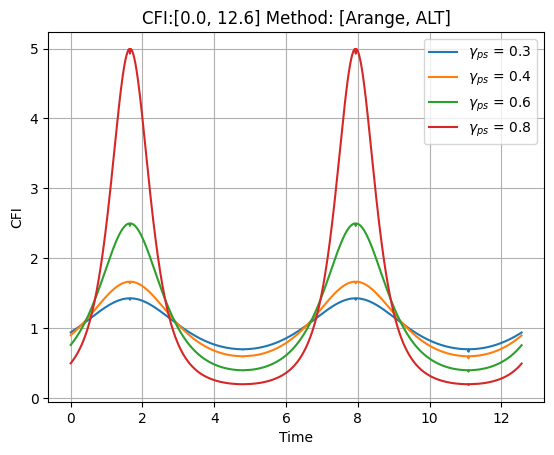

In [8]:
Sweep_range_0 = np_.array([1e-4, np.pi * 4 + 1e-4])
Gamma_0 =  3e-1, 4e-1, 6e-1, 8e-1
CFI_arange(Sweep_range_0, 1e-2, Gamma_0)

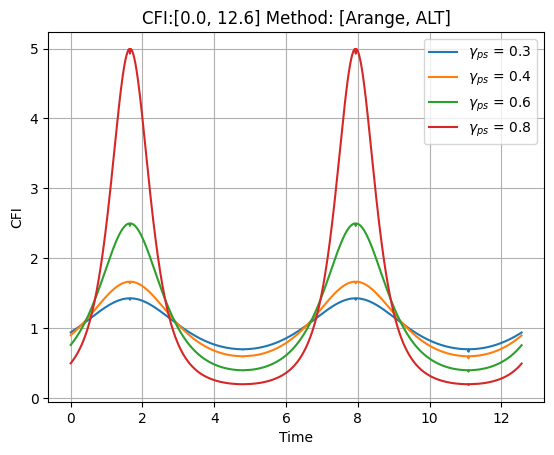

In [9]:
CFI_arange(Sweep_range_0, 1e-2, Gamma_0)

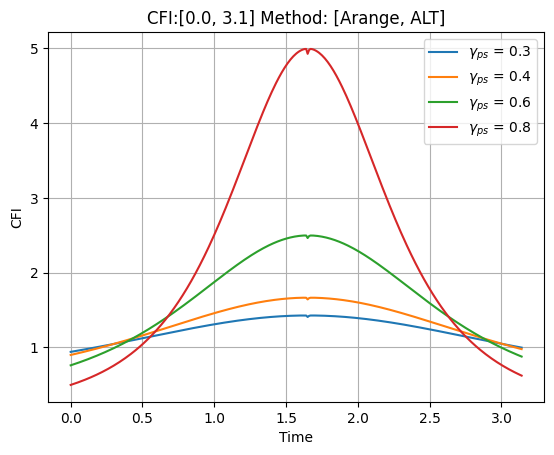

In [10]:
Sweep_range_1 = np_.array([1e-4, np.pi * 1 + 1e-4])

CFI_arange(Sweep_range_1, 1e-2, Gamma_0)